# Bank Marketing & Term Deposit Prediction Analysis
This project focuses on analyzing data from direct marketing campaigns by a Portuguese banking institution, where phone calls were made to clients in order to determine if they would subscribe to a bank term deposit. The goal is to identify which features have the most impact on predicting whether a client will subscribe to a term deposit (*yes*) or not (*no*). By exploring the relationship between various client characteristics and their likelihood of subscription, this analysis aims to provide insights into the key drivers behind successful marketing outcomes. 

_You can access the dataset via the following link: [Bank Marketing Dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing). Keep in mind, for this project, I used **bank-full.csv**, processed it roughly in Power Query, and renamed as bank.csv before going into this analysis._

## Asking Questions
  
* What are the correlations between the attributes?
* Is there a specific job type more likely to subscribe to a term deposit?
* What range of average balances is most associated with people subscribing to a term deposit?
* How do the attributes "credit in default" (`default`), "housing loan" (`housing`), and "personal loan" (`loan`) individually, or in combination, affect the likelihood of a client subscribing to a term deposit?

In [235]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

df = pd.read_csv(r'D:\DA data\bank.csv')

In [27]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,outcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


## Attribute Description

**A. Bank Client Data**
1. age 
2. job : type of job (*eg. "admin","unknown","unemployed","management","housemaid","entrepreneur","student","blue collar","self employed","retired","technician","services"*) 
3. marital : marital status (*eg. "married","divorced","single"; note: "divorced" means divorced or widowed*)
4. education (*eg. "unknown","secondary","primary","tertiary"*)
5. default: has credit in default? (*binary: "yes","no"*)
6. balance: average yearly balance, in euros
7. housing: has housing loan? (*binary: "yes","no"*)
8. loan: has personal loan? (*binary: "yes","no"*)

**B. Related with the last contact of the current campaign**

9. contact: contact communication type (*eg. "unknown","telephone","cellular"*) 
10. day: last contact day of the month 
11. month: last contact month of year (*eg. "jan", "feb", "mar", ..., "nov", "dec"*)
12. duration: last contact duration, in seconds 

**C. Other Attributes**

  13. campaign: number of contacts performed during this campaign and for this client, includes last contact
  14. pdays: number of days that passed by after the client was last contacted from a previous campaign (*numeric, -1 means client was not previously contacted*)
  15. previous: number of contacts performed before this campaign and for this client
  16. outcome: outcome of the previous marketing campaign (*eg. "unknown","other","failure","success"*)

**D. Output Variable (desired target):**  

  17. y - has the client subscribed a term deposit? (*binary: "yes","no"*)

In [258]:
# Convert month names to numbers
month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5,
    'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10,
    'nov': 11, 'dec': 12
}

df['month'] = df['month'].map(month_mapping)
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,outcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,5,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,5,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,5,76,1,-1,0,unknown,no
3,47,blue collar,married,unknown,no,1506,yes,no,unknown,5,5,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,5,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,11,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,11,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,11,1127,5,184,3,success,yes
45209,57,blue collar,married,secondary,no,668,no,no,telephone,17,11,508,4,-1,0,unknown,no


## Attribute Correlation Analysis

In [256]:
# Create a copy of df called df1
df1 = df.copy()

# Numerical Encoding of Categorical Variables
df_numerized = df1
for col_name in df_numerized.columns:
    if(df_numerized[col_name].dtype == 'object'):
        df_numerized[col_name]=df_numerized[col_name].astype('category')
        df_numerized[col_name]=df_numerized[col_name].cat.codes

df_numerized

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,outcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,9,1,2,0,825,0,0,0,17,9,977,3,-1,0,3,1
45207,71,5,0,0,0,1729,0,0,0,17,9,456,2,-1,0,3,1
45208,72,5,1,1,0,5715,0,0,0,17,9,1127,5,184,3,2,1
45209,57,1,1,1,0,668,0,0,1,17,9,508,4,-1,0,3,0


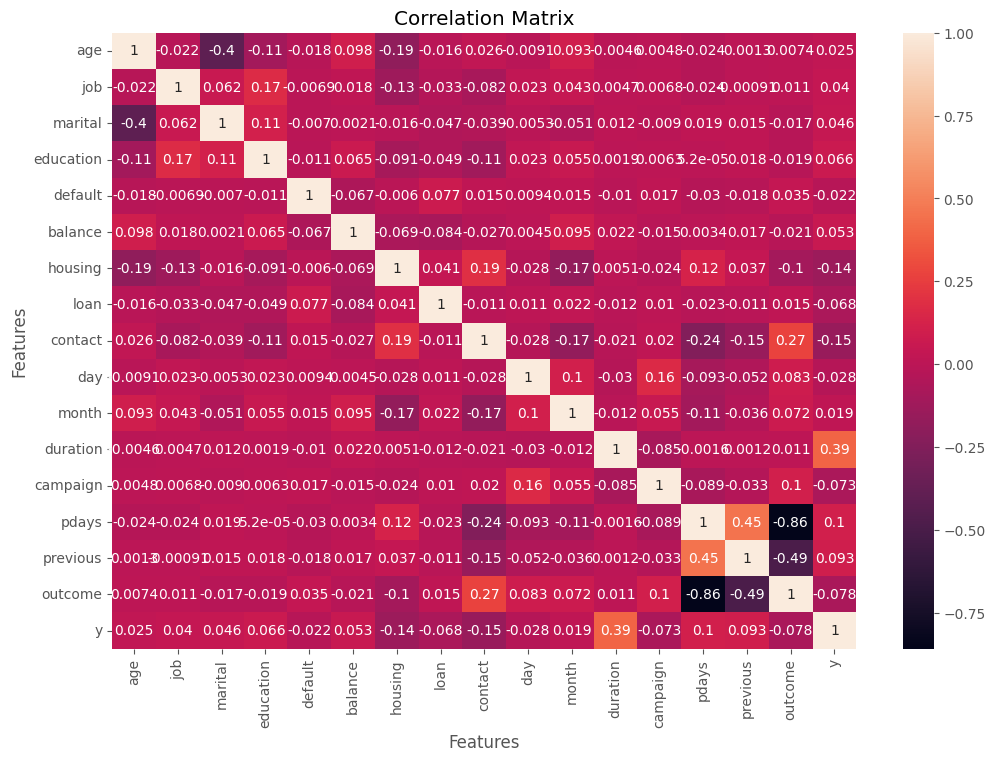

In [33]:
# Correlation Analysis and Heatmap Visualization for All Features
correlation_matrix = df_numerized.corr(method="pearson")
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

### Q1: What are the correlationships between the attributes?

In [35]:
correlation_mat = df_numerized.corr()
corr_pairs = correlation_mat.unstack()
corr_pairs

age  age          1.000000
     job         -0.021868
     marital     -0.403240
     education   -0.106807
     default     -0.017879
                    ...   
y    campaign    -0.073172
     pdays        0.103621
     previous     0.093236
     outcome     -0.077840
     y            1.000000
Length: 289, dtype: float64

In [37]:
sorted_pairs = corr_pairs.sort_values()
sorted_pairs

outcome    pdays       -0.858362
pdays      outcome     -0.858362
previous   outcome     -0.489752
outcome    previous    -0.489752
age        marital     -0.403240
                          ...   
education  education    1.000000
marital    marital      1.000000
job        job          1.000000
outcome    outcome      1.000000
y          y            1.000000
Length: 289, dtype: float64

In [124]:
high_positive_corr = sorted_pairs[((sorted_pairs) > 0.4) & ((sorted_pairs) < 1)]
high_positive_corr

previous  pdays       0.45482
pdays     previous    0.45482
dtype: float64

In [49]:
high_negative_corr = sorted_pairs[((sorted_pairs) < -0.4) & ((sorted_pairs) > -1)]
high_negative_corr

outcome   pdays      -0.858362
pdays     outcome    -0.858362
previous  outcome    -0.489752
outcome   previous   -0.489752
age       marital    -0.403240
marital   age        -0.403240
dtype: float64

**Answer:** 

The analysis reveals **4 key insights**:
1. There is a strong positive relationship between the number of days since the client was last contacted (`pdays`) and the number of contacts performed before this campaign (`previous`), suggesting that clients with fewer previous contacts tend to have longer gaps since their last contact.

2. A strong negative relationship exists between the outcome of the previous marketing campaign (`outcome`) and the number of days since the client was last contacted (`pdays`), indicating that clients who were not contacted recently are more likely to have an "unknown" or "other" outcome.

3. Similarly, there is a strong negative relationship between the number of previous contacts (`previous`) and the outcome of the previous marketing campaign (`outcome`), suggesting that clients with more previous contacts are less likely to have a successful outcome in the previous campaign.

4. A moderate negative relationship exists between age (`age`) and marital status (`marital`), with younger clients being more likely to be "single" and older clients tending to have a higher likelihood of being "married" or "divorced" (widowed).

### Q2: Is there a specific job type more likely to subscribe to a term deposit?

In [218]:
# Group by balance range and count term deposit subscriptions ('yes' and 'no')
job_deposit_counts = df.groupby(['job', 'y'], observed=True).size().unstack(fill_value=0)

# Calculate the total count (sum of 'yes' and 'no') for each balance range
job_deposit_counts['total'] = job_deposit_counts['yes'] + job_deposit_counts['no']

# Calculate the success rate (percentage of 'yes' counts)
job_deposit_counts['subscription_rate'] = (job_deposit_counts['yes'] / job_deposit_counts['total']) * 100

# Sort by subscription_rate in descending order
job_deposit_counts_sorted = job_deposit_counts.sort_values(by='subscription_rate', ascending=False)

# Display the result
print(job_deposit_counts_sorted)

y                no   yes  total  subscription_rate
job                                                
student         669   269    938          28.678038
retired        1748   516   2264          22.791519
unemployed     1101   202   1303          15.502686
management     8157  1301   9458          13.755551
admin          4540   631   5171          12.202669
self employed  1392   187   1579          11.842939
unknown         254    34    288          11.805556
technician     6757   840   7597          11.056996
services       3785   369   4154           8.883004
housemaid      1131   109   1240           8.790323
entrepreneur   1364   123   1487           8.271688
blue collar    9024   708   9732           7.274969


**Answer: Students & Retired people are more likely to subscribe to a term deposit.**

### Q3: What range of average balances is most associated with people subscribing to a term deposit?

In [122]:
# View the min, 25%, 50%, 75%, max balance
negative_bal = df['balance'].min()
print(f"Min negative (including negative balance):  {negative_bal}")

non_negative_bal = df[df['balance'] > 0]
non_negative_stats = non_negative_bal['balance'].describe()
print("\nDescriptive Statistics for Non-Negative Balances:")
print(non_negative_stats)

Min negative (including negative balance):  -8019

Descriptive Statistics for Non-Negative Balances:
count     37931.000000
mean       1655.270254
std        3240.126649
min           1.000000
25%         226.500000
50%         644.000000
75%        1776.000000
max      102127.000000
Name: balance, dtype: float64


In [134]:
# Bin edges that will be used to classify the data into groups
bin_edges = [-8019, 0, 226.5, 644, 1776, 102127]

# Labels for the four acidity level groups
bin_names = ['negative', 'low', 'moderate', 'high', 'very high'] # Name each acidity level category

In [136]:
# Creates acidity_levels column
df['balance_range'] = pd.cut(df['balance'], bin_edges, labels=bin_names)

# Checks for the successful creation of this column
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,outcome,y,balance_range
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,5,261,1,-1,0,unknown,no,very high
1,44,technician,single,secondary,no,29,yes,no,unknown,5,5,151,1,-1,0,unknown,no,low
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,5,76,1,-1,0,unknown,no,low
3,47,blue collar,married,unknown,no,1506,yes,no,unknown,5,5,92,1,-1,0,unknown,no,high
4,33,unknown,single,unknown,no,1,no,no,unknown,5,5,198,1,-1,0,unknown,no,low


In [220]:
# Group by balance range and count term deposit subscriptions ('yes' and 'no')
term_deposit_counts = df.groupby(['balance_range', 'y'], observed=True).size().unstack(fill_value=0)

# Calculate the total count (sum of 'yes' and 'no') for each balance range
term_deposit_counts['total'] = term_deposit_counts['yes'] + term_deposit_counts['no']

# Calculate the success rate (percentage of 'yes' counts)
term_deposit_counts['subscription_rate'] = (term_deposit_counts['yes'] / term_deposit_counts['total']) * 100

# Sort by subscription_rate in descending order
term_deposit_counts_sorted = term_deposit_counts.sort_values(by='subscription_rate', ascending=False)

# Display the result
print(term_deposit_counts_sorted)

y                no   yes  total  subscription_rate
balance_range                                      
very high      7926  1556   9482          16.410040
high           8224  1250   9474          13.194005
moderate       8388  1104   9492          11.630847
low            8606   877   9483           9.248128
negative       6777   502   7279           6.896552


**Answer: "Very High" balance has Higher Successful Subscription Rate (16.41%). Therefore, people with a "Very High" balance are more likely to subscribe to a term deposit.**

### Q4: How do the attributes "credit in default" (`default`), "housing loan" (`housing`), and "personal loan" (`loan`) individually, or in combination, affect the likelihood of a client subscribing to a term deposit?

In [227]:
# Analyze the effect of 'default' on subscription rate
default_subscription = df.groupby('default')['y'].value_counts(normalize=True).unstack(fill_value=0)

# Analyze the effect of 'housing' on subscription rate
housing_subscription = df.groupby('housing')['y'].value_counts(normalize=True).unstack(fill_value=0)

# Analyze the effect of 'loan' on subscription rate
loan_subscription = df.groupby('loan')['y'].value_counts(normalize=True).unstack(fill_value=0)

# Display the results
print("Subscription Rate by Default:")
print(default_subscription)
print("\nSubscription Rate by Housing Loan:")
print(housing_subscription)
print("\nSubscription Rate by Personal Loan:")
print(loan_subscription)

Subscription Rate by Default:
y              no       yes
default                    
no       0.882039  0.117961
yes      0.936196  0.063804

Subscription Rate by Housing Loan:
y              no       yes
housing                    
no       0.832976  0.167024
yes      0.923000  0.077000

Subscription Rate by Personal Loan:
y           no       yes
loan                    
no    0.873443  0.126557
yes   0.933186  0.066814


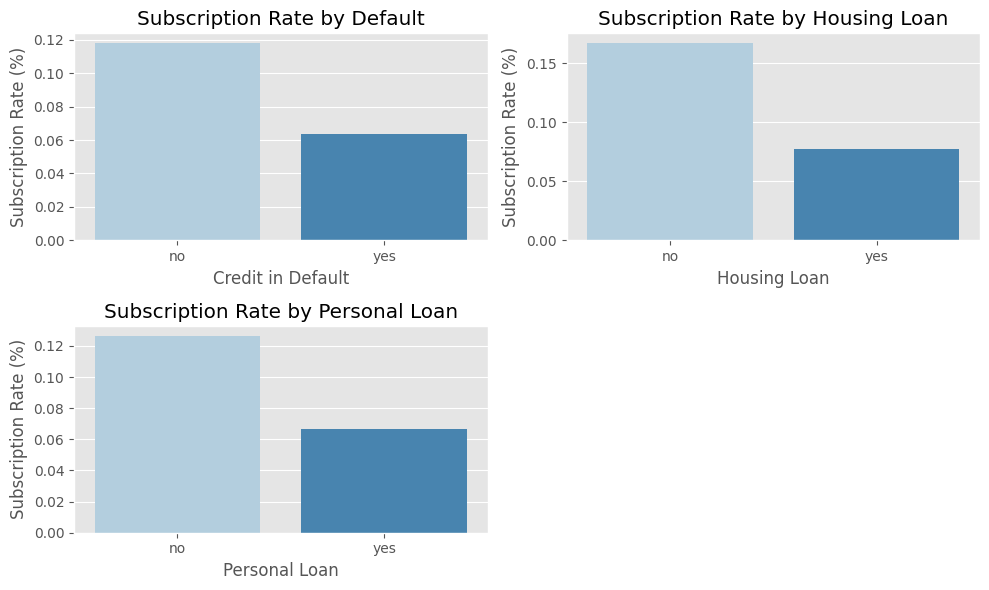

In [252]:
# Visualize the effect of each attribute on subscription rate
plt.figure(figsize=(10, 6))

# Default
plt.subplot(2, 2, 1)
sns.barplot(x=default_subscription.index, y=default_subscription['yes'], hue=default_subscription.index, palette='Blues', legend=False)
plt.title("Subscription Rate by Default")
plt.xlabel("Credit in Default")
plt.ylabel("Subscription Rate (%)")

# Housing Loan
plt.subplot(2, 2, 2)
sns.barplot(x=housing_subscription.index, y=housing_subscription['yes'], hue=housing_subscription.index, palette='Blues', legend=False)
plt.title("Subscription Rate by Housing Loan")
plt.xlabel("Housing Loan")
plt.ylabel("Subscription Rate (%)")

# Personal Loan
plt.subplot(2, 2, 3)
sns.barplot(x=loan_subscription.index, y=loan_subscription['yes'], hue=loan_subscription.index, palette='Blues', legend=False)
plt.title("Subscription Rate by Personal Loan")
plt.xlabel("Personal Loan")
plt.ylabel("Subscription Rate (%)")

plt.tight_layout()
plt.show()


In [231]:
# Combine the attributes 'default', 'housing', 'loan' and calculate subscription rates
combined_subscription = df.groupby(['default', 'housing', 'loan'])['y'].value_counts(normalize=True).unstack(fill_value=0)

# Display the result
print(combined_subscription)

y                           no       yes
default housing loan                    
no      no      no    0.816384  0.183616
                yes   0.922111  0.077889
        yes     no    0.919457  0.080543
                yes   0.939065  0.060935
yes     no      no    0.929245  0.070755
                yes   0.952381  0.047619
        yes     no    0.927152  0.072848
                yes   0.947368  0.052632


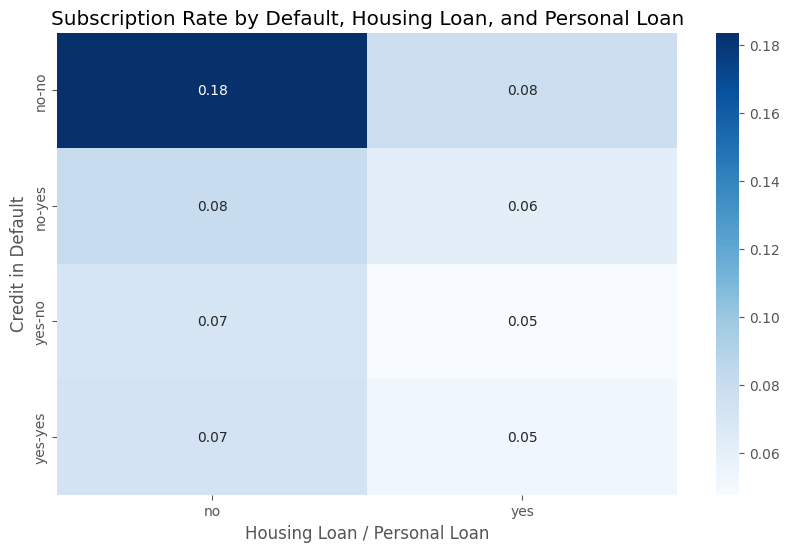

In [254]:
# Visualize the combined effect of 'default', 'housing', and 'loan' on successful subscription rate
plt.figure(figsize=(10, 6))
sns.heatmap(combined_subscription['yes'].unstack(), annot=True, cmap='Blues', fmt='.2f')
plt.title("Subscription Rate by Default, Housing Loan, and Personal Loan")
plt.xlabel("Housing Loan / Personal Loan")
plt.ylabel("Credit in Default")
plt.show()

In [237]:
# Create a contingency table for 'default' vs 'subscription'
contingency_default = pd.crosstab(df['default'], df['y'])
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_default)
print(f"Chi-squared test result for 'default' vs 'subscription': p-value = {p_val}")

# Create a contingency table for 'housing' vs 'subscription'
contingency_housing = pd.crosstab(df['housing'], df['y'])
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_housing)
print(f"Chi-squared test result for 'housing' vs 'subscription': p-value = {p_val}")

# Create a contingency table for 'loan' vs 'subscription'
contingency_loan = pd.crosstab(df['loan'], df['y'])
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_loan)
print(f"Chi-squared test result for 'loan' vs 'subscription': p-value = {p_val}")

Chi-squared test result for 'default' vs 'subscription': p-value = 2.4538606753508344e-06
Chi-squared test result for 'housing' vs 'subscription': p-value = 2.918797605076633e-192
Chi-squared test result for 'loan' vs 'subscription': p-value = 1.665061163492756e-47


**Answer**

1. Credit in Default (`default`): `p-value = 2.45e-06`, indicating a significant impact on subscription likelihood.
2. Housing Loan (`housing`): `p-value = 2.92e-192`, showing a very strong association with higher subscription rates.
3. Personal Loan (`loan`): `p-value = 1.67e-47`, indicating a significant but less strong relationship with subscription likelihood.

_In summary, clients with a **housing loan** are most likely to subscribe to a term deposit, followed by those with a **personal loan** and those with **credit in default**._